In [7]:
import sys
sys.path.append('.')

import anndata
import time, os, sys
from datetime import datetime

import pandas as pd
import glob
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np

#import skimage.io as io
import scimap as sm
import scanpy as sc

# libraries for patch function
# Import library
import pandas as pd#
from sklearn.neighbors import BallTree
import numpy as np
from joblib import Parallel, delayed
import scipy
from functools import reduce

This script runs COZI on simulated data using the scimap fork https://github.com/chiarasch/scimap

In [8]:
# Load in dataset. This is a .csv file with all samples concatenated together, either for symmetric or asymmetric data
path_to_csv = './../../../../../data/20250217_asym01_nbh2_1000dim_grid200_300iter_50swaps'
output_path_COZI_NEP = './../../../../Comparison/20250218_results_asym/COZI_delaunay_4ct_cross01.csv'

In [9]:

# read in all csv files (they all have ct, x and y coordinates) give them a new sample id column of their file names and row bind them all to one big dataframe
# Use glob to get all the CSV files in the folder
csv_files = glob.glob(os.path.join(path_to_csv, '*.csv'))

# Initialize an empty list to store individual DataFrames
data_frames = []

# Loop through the CSV files and process each one
for file in csv_files[1:10]:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    sample_id = os.path.splitext(os.path.basename(file))[0]
    df['sample_id'] = sample_id
    data_frames.append(df)
    
# Concatenate all DataFrames into one big DataFrame
obs = pd.concat(data_frames, ignore_index=True)


In [4]:
# for image, show the counts of unique ct
print(obs['ct'].value_counts())

ct
1.00    4302
0.00    4038
2.00    3901
3.00    3828
Name: count, dtype: int64


In [10]:
# add marker files to it, as SpatialLDA needs them
obs['D'] = np.random.randint(1, 101, size=len(obs))
obs['E'] = np.random.randint(1, 101, size=len(obs))

# Load dataframe into anndata object
# dataframe for annotating the observations
obs = obs.astype({'ct':'string'})

# the data matrix 
X = obs[['D', 'E']]
X = X.values
adata = anndata.AnnData(X)
adata.obs = obs

adata.obs

,x,y,ct,sample_id,D,E
0,0.00,0.00,3.0,cross01_0.6_ab0_0.55_24,43,11
1,27.40,0.00,1.0,cross01_0.6_ab0_0.55_24,57,33
2,50.56,0.00,3.0,cross01_0.6_ab0_0.55_24,26,30
3,74.40,0.00,0.0,cross01_0.6_ab0_0.55_24,10,36
4,98.07,0.00,0.0,cross01_0.6_ab0_0.55_24,6,45
...,...,...,...,...,...,...
16064,161.09,167.95,2.0,cross01_0.45_ab0_0.15_78,37,55
16065,613.71,130.12,2.0,cross01_0.45_ab0_0.15_78,79,19
16066,728.30,829.93,1.0,cross01_0.45_ab0_0.15_78,36,70
16067,238.96,709.52,1.0,cross01_0.45_ab0_0.15_78,75,29


In [13]:
# run spatial interaction to look at interaction of phenotypes without motifs
sm.tl.spatial_interaction(adata, 
                          phenotype='ct', 
                          x_coordinate='x', y_coordinate='y', 
                          imageid='sample_id', 
                          #knn=8, 
                          permutation = 300,
                          method='delaunay',
                          verbose=True,
                          normalization = 'conditional',
                          pval_method = 'zscore',
                          label='delauany_zscore_scimap')

Processing Image: ['cross01_0.6_ab0_0.55_24']
Performing Delaunay triangulation to identify neighbours for every cell
Mapping phenotype to neighbors
Performing 300 permutations
Consolidating the permutation results
Processing Image: ['ran_ab0_0.05_5']
Performing Delaunay triangulation to identify neighbours for every cell
Mapping phenotype to neighbors
Performing 300 permutations
Consolidating the permutation results
Processing Image: ['cross01_0.45_ab0_0.15_50']
Performing Delaunay triangulation to identify neighbours for every cell
Mapping phenotype to neighbors
Performing 300 permutations
Consolidating the permutation results
Processing Image: ['cross01_0.6_ab0_0.55_30']
Performing Delaunay triangulation to identify neighbours for every cell
Mapping phenotype to neighbors
Performing 300 permutations
Consolidating the permutation results
Processing Image: ['ran_ab0_0.45_49']
Performing Delaunay triangulation to identify neighbours for every cell
Mapping phenotype to neighbors
Perform

AnnData object with n_obs × n_vars = 16069 × 2
    obs: 'x', 'y', 'ct', 'sample_id', 'D', 'E'
    uns: 'delauany_zscore_scimap'

In [14]:
save_df = adata.uns['delauany_zscore_scimap']
# Convert 'phenotype' and 'neighbour_phenotype' columns to string types
save_df['phenotype'] = save_df['phenotype'].astype(str)
save_df['neighbour_phenotype'] = save_df['neighbour_phenotype'].astype(str)

# Combine 'phenotype' and 'neighbour_phenotype' into 'new_column'
save_df['new_column'] = save_df['phenotype'] + "_" + save_df['neighbour_phenotype']
save_df = save_df.drop(columns=['phenotype', 'neighbour_phenotype'])
save_df = save_df.set_index('new_column')

# Transpose the dataframe
save_df_transposed = save_df.transpose()
save_df_transposed.columns = save_df_transposed.columns.str.replace(r"\.0",
                                                                    "",
                                                                    regex=True)
save_df_transposed = save_df_transposed[~save_df_transposed.index.str.contains('pvalue')]
save_df_transposed = save_df_transposed[~save_df_transposed.index.str.contains('count')]
save_df_transposed.index = save_df_transposed.index.str.replace(r"zscore_", "", regex=True)

# View the transposed dataframe (optional)
save_df_transposed
# save the dataframe as csv
save_df_transposed.to_csv(output_path_COZI_NEP, index=True)

new_column,0_0,0_1,0_2,0_3,1_0,1_1,1_2,1_3,2_0,2_1,2_2,2_3,3_0,3_1,3_2,3_3
cross01_0.6_ab0_0.55_24,-3.53,4.03,0.58,2.00,-0.63,4.46,-2.50,-1.94,-0.38,-2.37,3.01,1.24,0.06,-2.14,1.70,4.35
ran_ab0_0.05_5,2.33,-0.42,0.73,-1.43,0.90,0.58,-0.25,0.49,1.30,0.38,-1.78,1.48,-0.46,-0.67,0.66,-1.13
cross01_0.45_ab0_0.15_50,-0.70,0.41,0.33,-0.29,1.06,2.13,0.01,-1.64,-1.02,-0.32,1.33,0.34,-1.15,-1.01,0.83,2.11
cross01_0.6_ab0_0.55_30,-3.60,4.86,1.02,-0.95,0.38,4.76,-2.57,0.05,-0.42,-4.08,2.94,3.99,-0.95,-2.72,3.08,2.46
ran_ab0_0.45_49,1.47,2.75,0.05,-0.14,-1.28,-1.54,-0.15,1.58,0.14,-1.52,0.54,-0.69,-0.27,1.86,-0.43,-0.54
ran_ab0_0.45_61,-1.59,0.48,-1.51,0.90,1.72,-2.32,-0.44,1.31,1.24,0.21,-2.17,-1.02,-0.30,-0.92,-1.15,-0.86
cross01_0.6_ab0_0.25_100,-3.96,2.82,2.92,-0.88,-0.10,3.99,-2.69,-1.03,-1.13,-2.67,1.33,0.54,-0.94,1.15,1.43,1.61
cross01_0.45_ab0_0.1_32,-1.96,1.43,1.35,0.72,2.18,0.52,-1.40,-0.71,-0.01,0.03,1.01,-0.48,-0.76,0.19,-1.43,1.63
cross01_0.45_ab0_0.15_78,-1.86,2.34,-0.07,0.87,0.27,-0.15,-0.10,0.34,-0.65,-0.12,0.25,0.15,-1.09,-0.21,0.39,-0.26


<Axes: xlabel='new_column'>

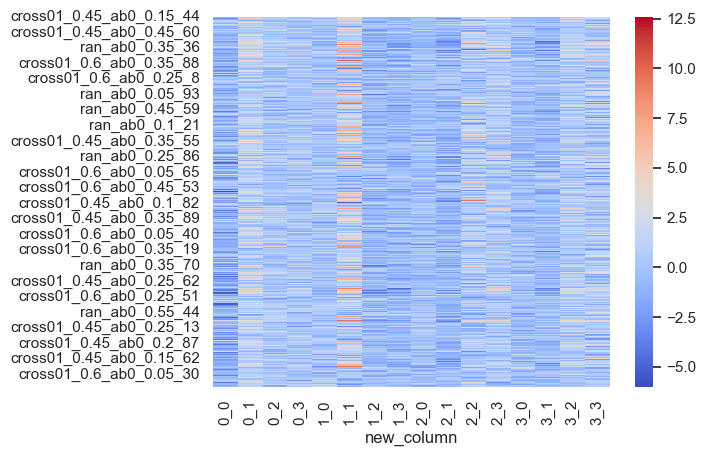

In [9]:
# show a heatmap of save_df_transposed
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(save_df_transposed, cmap='coolwarm')